# U.S. Medical Insurance Costs

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
df = pd.read_csv('insurance.csv')

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# Exploratory Data Analysis

What questions are we potentiall interested in asking?:

- What is the difference in metrics based on gender?

- What is the difference in metrics based on smoking?

- What is the difference based on region?

First, let's just figure out how many men v women we have, and how many smokers v non smokers, and group people by number of children as well. 

In [12]:
print('We have a total of '+str((df['sex']=='male').sum())+' males.')
print('We have a total of '+str((df['sex']=='female').sum())+' females.')

We have a total of 676 males.
We have a total of 662 females.


This is good, our dataset is balanced by gender. Any models we use will not be biased by this result. Let's check for smoking now.

In [13]:
print('We have a total of '+str((df['smoker']=='yes').sum())+' smokers.')
print('We have a total of '+str((df['smoker']=='no').sum())+' non-smokers.')

We have a total of 274 smokers.
We have a total of 1064 non-smokers.


Clearly, we have significantly more non-smokers than smokers (good thing!), which means we must be careful our predictor is not predicting based soley on this value alone.

Perhaps we should look at the distribution of insurance values in total? A histogram is perfect for this.

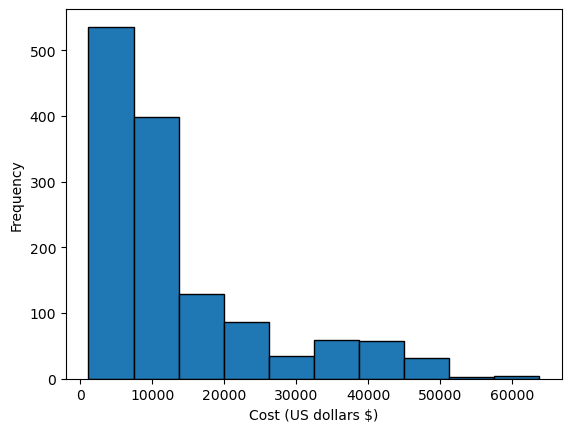

In [14]:
plt.hist(df['charges'],bins=10,edgecolor='black')
plt.xlabel('Cost (US dollars $)')
plt.ylabel('Frequency')
plt.show()

It seems the majority of insuirance users cost below 20K with outliers past 50K. For curiosity sakes, we should separate the histogram based on smokers and non-smokers. I imagine an obvious trend would emerge.

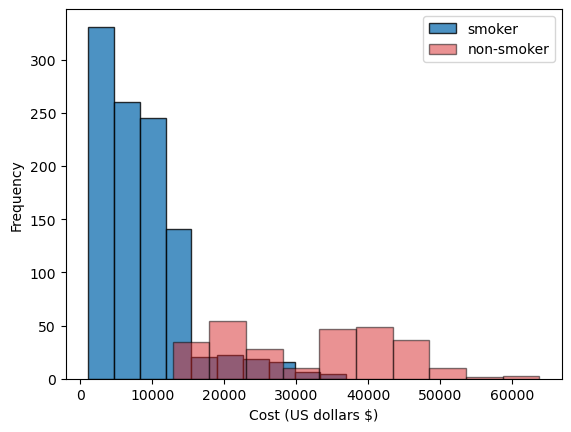

In [15]:
plt.hist(df[df['smoker']=='no']['charges'],bins=10,edgecolor='black',color='tab:blue',alpha=0.8,label = 'smoker')
plt.xlabel('Cost (US dollars $)')
plt.ylabel('Frequency')
plt.hist(df[df['smoker']=='yes']['charges'],bins=10,edgecolor='black',color='tab:red',alpha=0.5,label = 'non-smoker')
plt.xlabel('Cost (US dollars $)')
plt.ylabel('Frequency')
plt.legend()

plt.show()

As I suspected, the majority of the upper end costs are related to smoking. Let's do a similar histogram with gender.

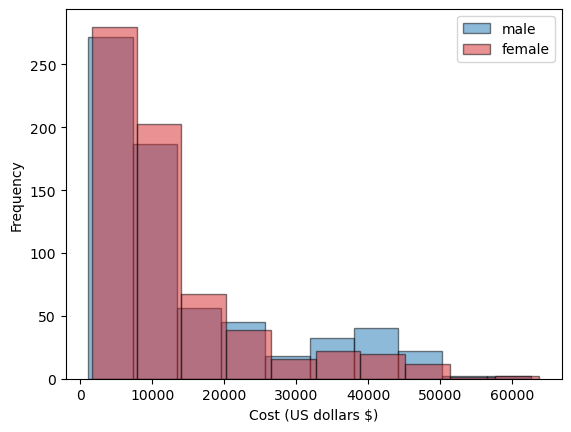

In [16]:
plt.hist(df[df['sex']=='male']['charges'],bins=10,edgecolor='black',color='tab:blue',alpha=0.5,label = 'male')
plt.xlabel('Cost (US dollars $)')
plt.ylabel('Frequency')
plt.hist(df[df['sex']=='female']['charges'],bins=10,edgecolor='black',color='tab:red',alpha=0.5,label = 'female')
plt.xlabel('Cost (US dollars $)')
plt.ylabel('Frequency')
plt.legend()

plt.show()

While males are slightly shifted to upper costs, this difference is not emourmous. Gender is likely not the second strongest discriminator (smoking being the first) on costs.

Last, we plot a bar chart based on kids and then on region.

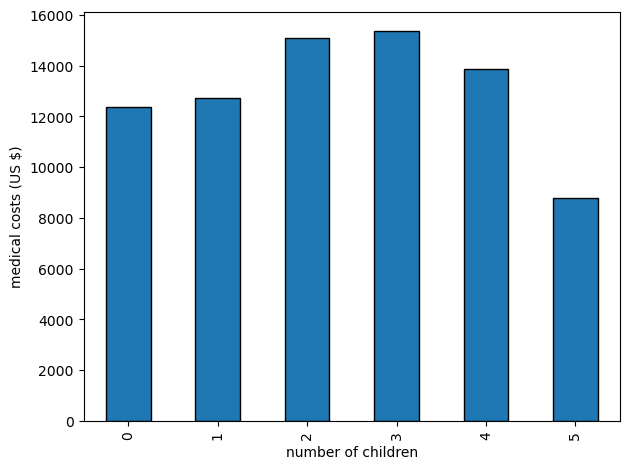

In [17]:
kids = df.groupby('children')['charges'].mean()

kids.plot(kind='bar',edgecolor='black')
plt.xlabel('number of children')
plt.ylabel('medical costs (US $)')
plt.tight_layout()

Unexpectedly, the cost goes back down as the number of children increase? Does this insurance cost account for any government subsidies that may be present? It is not as strong of a predictor as I would have expected. I would have anticipated a linear trend to the cost....

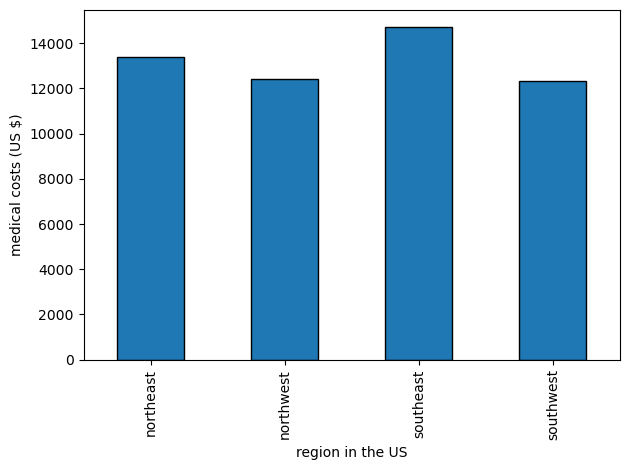

In [18]:
kids = df.groupby('region')['charges'].mean()

kids.plot(kind='bar',edgecolor='black')
plt.xlabel('region in the US')
plt.ylabel('medical costs (US $)')
plt.tight_layout()

This is close to what I expected. The difference is non-trivial, but not enourmous either. It is possible the variations in costs have little to do with region, and region is somehow tied to smoking popularity.

Okay, I believe we have performed enough exploratory data analysis to get a sense of how to build a cost predictor. 

We should try two approaches:

- Approach one: An analytical predictor which uses PCA to determinet the ideal 'coordinates' for a cost function. This approach has a reproducable mathematical structure that can be clearly understood by humans. We may need to remove the 'smoker' category temporary in the dimension reduction and add a flat value afterwards to help determine the cost.
- Approach two: Use a random forest algorithm to find the best categories. This approach may make decisions that are strange, but effective. 

Before we do any dimension reduction, we should consider looking at a correlation matrix between ALL variables. We need to encode our categorical variables to do this, so this will take priority.

To include the categorical variables in the determination, we will need to use encoding to treat them as a numerical category. I guess one-hot encoding is a good default option.

# Correlation Matrix

In [26]:
#import relevant pipelines.
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [68]:
#Since we want the charge included in the correlation matrix, we need to keep all columns for encoding. 

numeric_X = df.select_dtypes(include=['number'])
categorical_X = df.select_dtypes(include=['object','category']) #I guess object and category are needed to capture all versions of categories...

#grab the columns from these:
numeric_X_col = numeric_X.columns.tolist()
categorical_X_col = categorical_X.columns.tolist()


In [69]:
#time to build ColumnTransformer, I am not super familiar with this tool so time to learn now I guess.

preprocessor = sklearn.compose.ColumnTransformer([
    ('num', StandardScaler(), numeric_X_col),
    ('cat',OneHotEncoder(drop=None),categorical_X_col) #want the argument to be none when looking at a correlation matrix.
])

#okay, it's just a little box which repackes our data to 'look' all numerical when it isn't. neat!


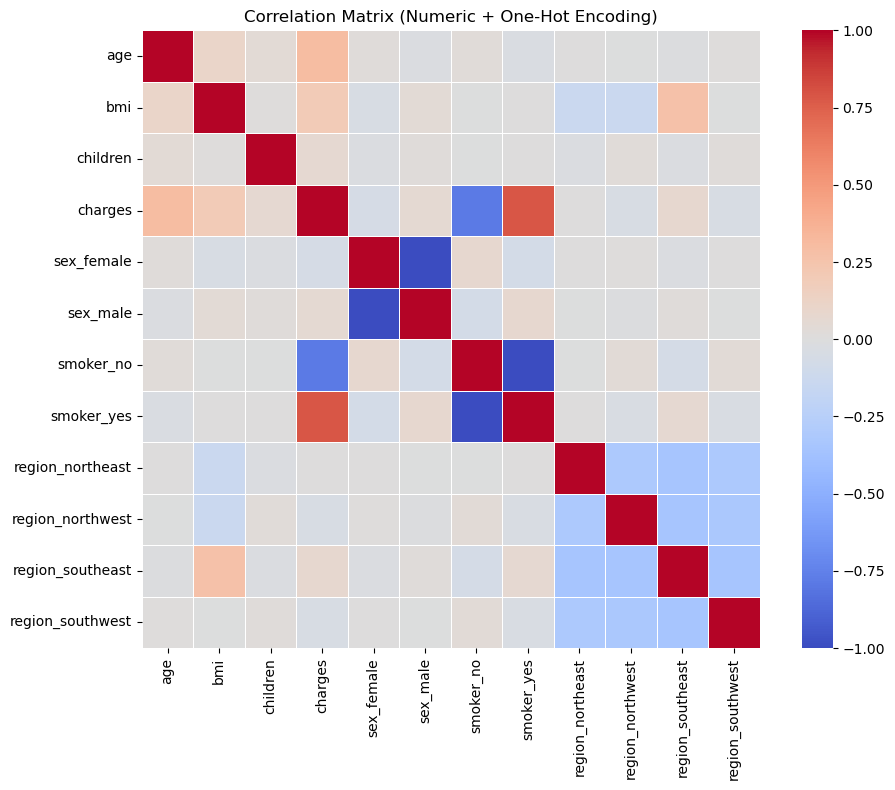

In [73]:
#now that the encoder is built, let's apply it and compute that correlation matrix!
encoded_df = preprocessor.fit_transform(df)

# 5. Recover feature names
num_names = numeric_X_col
cat_names = preprocessor.named_transformers_['cat'] \
                   .get_feature_names_out(categorical_X_col).tolist()
all_names = num_names + cat_names

# 6. Build a DataFrame of the encoded features
enc_df = pd.DataFrame(encoded_df, columns=all_names, index=df.index)

# 7. Compute the correlation matrix
corr = enc_df.corr()

# 8. Plot as a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    annot=False,
    square=True,
    linewidths=0.5
)
plt.title('Correlation Matrix (Numeric + One-Hot Encoding)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


It is now very clear. The value of your charges are best explained by age, bmi, and smoking status. There is a weak correlation with the southeast, which is also correlated with BMI (This makes sense, too much fried chicken and gravy down here in the south lol).An intuitive based model could easily drop the other dimensions as irrelevant and calculate based only on the high impact factors. Honestly, I think even performing PCA is uncessary after looking at the correlations in full. 

In [11]:
#to do what is described above, we will randomly sample 10% of the data to use for benchmarking, both for linear regression and random forest.

benchmark_df = df.sample(frac=0.1, random_state = 42)
test_df = df.drop(benchmark_df.index)



# linear regression using BMI, age, and smoking status

In [30]:
#break up respective data groups.
X_train = benchmark_df[['age','bmi','smoker']]
X_test = test_df[['age','bmi','smoker']]

Y_train = benchmark_df['charges']
Y_test = test_df['charges']

In [31]:

# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Create the preprocessing pipeline
preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# Create the full pipeline with a linear regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the pipeline
pipeline.fit(X_train, Y_train)

# Extract feature names and coefficients
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = pipeline.named_steps['regressor'].coef_

# Display coefficients alongside feature names
#coef_df = pd.DataFrame({
#    'feature': feature_names,
#    'coefficient': coefficients
#})
print(feature_names)
print('\n')
print(coefficients)

['num__age' 'num__bmi' 'cat__smoker_yes']


[ 3339.23291896  2388.47591503 23161.35982552]


This means the ideal cost predictor is something like:

charge = 3339.23291 x age + 2388.475 x BMI + 23161.35 x smoker

where you enter 1 for yes, and 0 for no smoking.

Let's see how this fit holds up with the test data.

In [32]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Y_pred = pipeline.predict(X_test)


r2  = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = mse**0.5
mae = mean_absolute_error(Y_test, Y_pred)

print(f"R² score:           {r2:.3f}")
print(f"Mean squared error: {mse:.3f}")
print(f"Root MSE:           {rmse:.3f}")
print(f"Mean absolute error:{mae:.3f}")


R² score:           0.740
Mean squared error: 38312598.458
Root MSE:           6189.717
Mean absolute error:4323.557


# Random Forest algorithm

Generally, these algorithms can find more nuanced detials for better pricing power. However, they should come to the same conclusion as we do and determine that BMI, smoking, and age should dominate the tree. If not, there is something wrong.

In [33]:
import xgboost
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report


In [34]:

#create the random forest
rf = RandomForestRegressor(
    n_estimators = 30, #number of trees. I think more than this would be excessive.
    max_depth=None,
    min_samples_leaf=1,
    random_state=42
)


# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Create the preprocessing pipeline, include the random forest in it.
preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# Create the full pipeline with a linear regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', rf)
])

pipeline.fit(X_train,Y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['smoker'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=30, random_state=42))])

In [35]:
Y_pred = pipeline.predict(X_test)


r2  = r2_score(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = mse**0.5
mae = mean_absolute_error(Y_test, Y_pred)

print(f"R² score:           {r2:.3f}")
print(f"Mean squared error: {mse:.3f}")
print(f"Root MSE:           {rmse:.3f}")
print(f"Mean absolute error:{mae:.3f}")

R² score:           0.795
Mean squared error: 30159515.342
Root MSE:           5491.768
Mean absolute error:3245.494


Definitely an overall improvement on the test data, but only by a margin (.74 -> .795). Let's see what kind of tree ended up being built to figure out what went wrong.

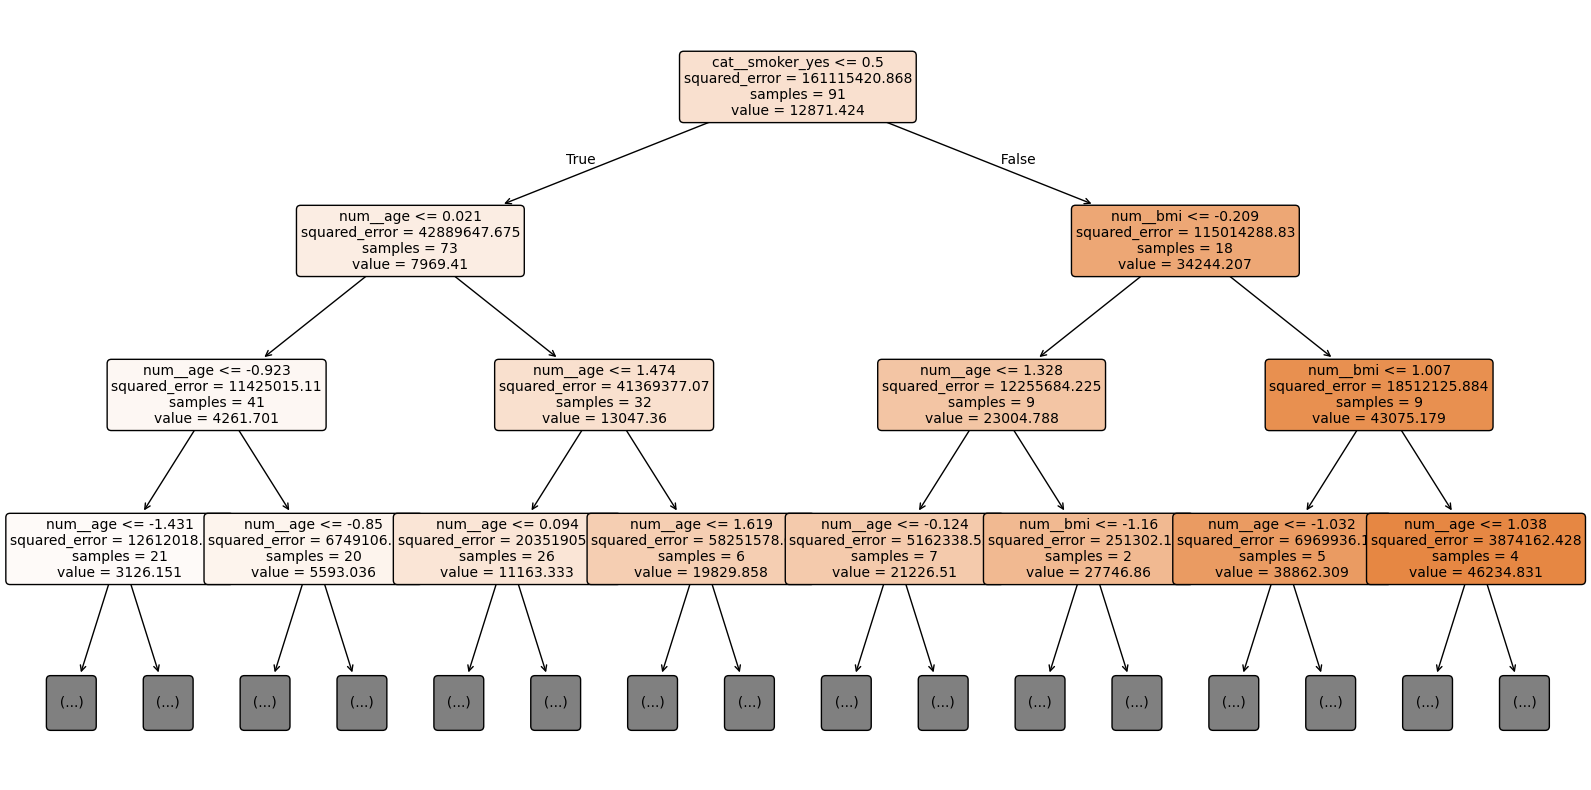

In [36]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# 1) Grab one of the fitted trees (e.g. the first one)
rf = pipeline.named_steps['regressor']
single_tree = rf.estimators_[0]

# 2) Recover the feature names after preprocessing
#    This will give you something like ['num__age', 'cat__gender_Male', …]
feature_names = pipeline.named_steps['preprocessor'] \
                        .get_feature_names_out(input_features=X_train.columns)

# 3) Plot it
plt.figure(figsize=(20, 10))
plot_tree(
    single_tree,
    feature_names=feature_names,
    filled=True,        # color by value
    rounded=True,       # rounded boxes
    max_depth=3,        # only show top 3 levels for readability
    fontsize=10
)
plt.show()

That's all for now folks!
-Tyler